In [1]:
import numpy as np
import pandas as pd
import healpy as hp
import dask
import hats
import lsdb
import astropy
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy import units as u
import matplotlib.pyplot as plt
from scipy.stats import norm, gaussian_kde
from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d
from ugali.analysis.isochrone import factory as isochrone_factory
import os
import logging
import time
import sys
code_path = "/astro/users/esb30/software/spreading_seas/code"
sys.path.append(code_path)
from cmd_plots import plot_cmd_hist

In [2]:
dxg_aau = pd.read_parquet('/astro/users/esb30/software/spreading_seas/notebooks/dxg_aau.parquet')

In [3]:
print(f'Columns:\n{dxg_aau.columns}')

Columns:
Index(['coadd_object_id', 'ra', 'dec', 'phi1', 'phi2', 'g_mag', 'r_mag',
       'i_mag', 'z_mag', 'gaia', 'pmra', 'pmdec', 'pmra_error', 'pmdec_error',
       'pmphi1', 'pmphi2', 'pmra_score', 'pmdec_score', 'spatial_score'],
      dtype='object')


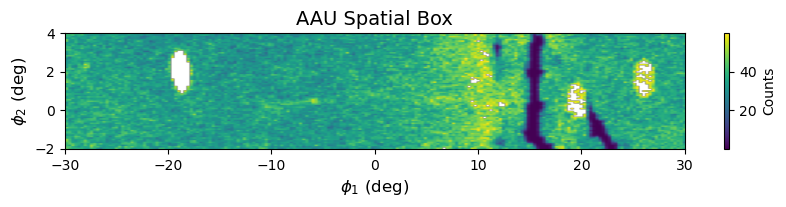

In [4]:
bins_x = np.linspace(-30, 30, 200)
bins_y = np.linspace(-2, 4, 80)
fig, ax = plt.subplots(1, 1, figsize=(10, 1.5))
H1, xedges, yedges = np.histogram2d(dxg_aau['phi1'], dxg_aau['phi2'], bins=[bins_x, bins_y])
smoothed_H1 = gaussian_filter(H1.T, sigma=0.5)
phi1_grid, phi2_grid = np.meshgrid((bins_x[:-1] + bins_x[1:])/2, (bins_y[:-1] + bins_y[1:])/2)
masked_H1 = np.ma.masked_where((smoothed_H1 > 60), smoothed_H1)
im = ax.imshow(
    masked_H1,
    extent=[bins_x[0], bins_x[-1], bins_y[0], bins_y[-1]],
    origin='lower',
    cmap='viridis',
    aspect='auto',
    #vmin=0,
    #vmax=80,
)
ax.set_xlabel(r'$\phi_1$ (deg)', fontsize=12)
ax.set_ylabel(r'$\phi_2$ (deg)', fontsize=12)
ax.set_title(rf'AAU Spatial Box', fontsize=14)
cbar = fig.colorbar(im, ax=ax, label='Counts')

Text(0.5, 1.0, 'Proper Motions in the AAU Field')

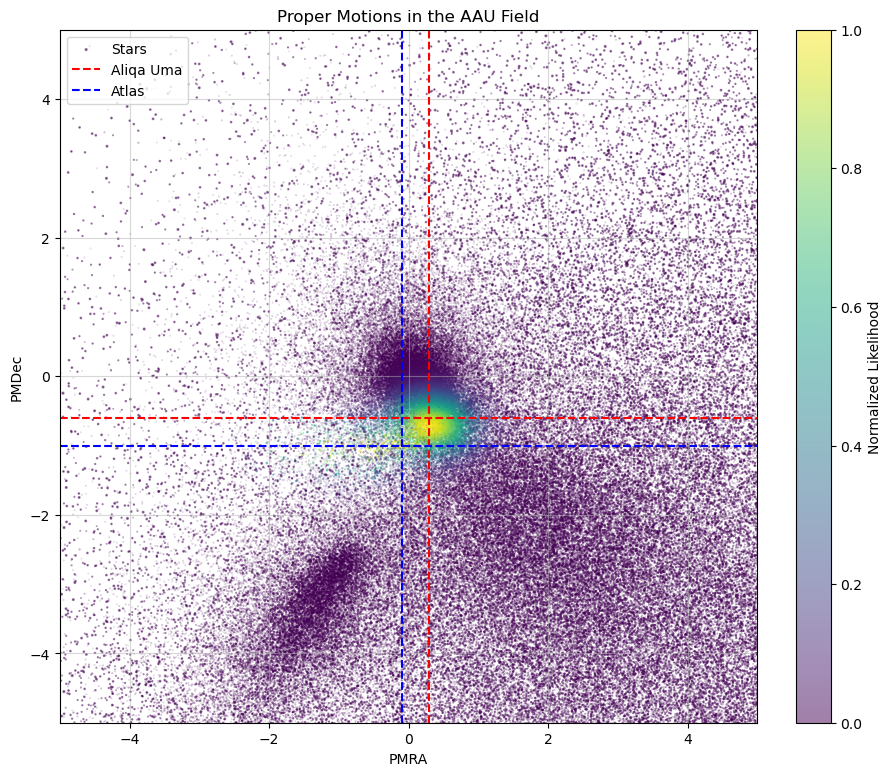

In [5]:
fig,ax=plt.subplots(1,1,figsize=[10,9])
cbar_min,cbar_max=0,1
df_pm = dxg_aau.dropna(subset=['pmra', 'pmdec'])
image = ax.scatter(df_pm['pmra'],df_pm['pmdec'],c=(df_pm['pmra_score'] * df_pm['pmdec_score']),s=0.05 / np.sqrt(df_pm['pmra_error']**2 + df_pm['pmdec_error']**2),alpha=0.5,label='Stars',cmap='viridis',vmin=cbar_min,vmax=cbar_max)
ax.grid(alpha=0.5)
ax.set_xlabel('PMRA')
ax.set_ylabel('PMDec')
ax.set_xlim(-5,5)
ax.set_ylim(-5,5)
cbar1 = fig.colorbar(image, ax=ax, label=r'Normalized Likelihood', fraction=0.05, ticks=None)
ax.axvline(x=0.3, color='red', linestyle='--', linewidth=1.5, label='Aliqa Uma')
ax.axhline(y=-0.6, color='red', linestyle='--', linewidth=1.5)
ax.axvline(x=-0.1, color='blue', linestyle='--', linewidth=1.5, label='Atlas')
ax.axhline(y=-1, color='blue', linestyle='--', linewidth=1.5)
ax.legend()
ax.set_title('Proper Motions in the AAU Field')
#fig.text(0.5, 0.01, r'Size = $\mathrm{Error}^{-1}$', ha='center', fontsize=10)

/astro/users/esb30/software/spreading_seas/code/cmd_plots.py:26: UserWarning: Adding colorbar to a different Figure <Figure size 1000x1000 with 2 Axes> than <Figure size 600x600 with 1 Axes> which fig.colorbar is called on.
  cbar = fig.colorbar(im1, ax=ax, label='Counts')


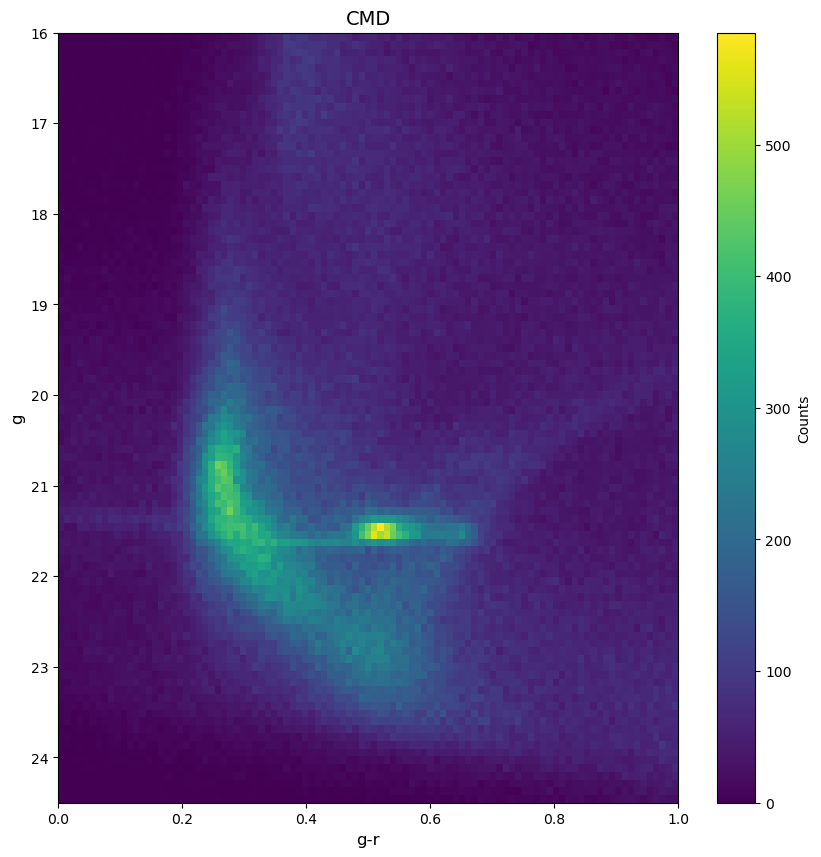

In [6]:
fig,ax=plt.subplots(1,1,figsize=[10,10])
plot_cmd_hist(g=dxg_aau['g_mag'],r=dxg_aau['r_mag'],ax=ax,sqrt_bin_count=100, cmap='viridis', title='CMD',bright_bound=16,faint_bound=24.5,lower_color=0,higher_color=1)